In [6]:
# imports 
# data manipulation 
import pandas as pd 
import numpy as np
import re

# visualizations 
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# sklearn 
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [7]:
# loading and displaying the data
df = pd.read_csv('GenerateTechChallengeData.csv')
df.head() 

,Month,AustralianPort,ForeignPort,Country,Passengers_In,Freight_In_(tonnes),Mail_In_(tonnes),Passengers_Out,Freight_Out_(tonnes),Mail_Out_(tonnes),Passengers_Total,Freight_Total_(tonnes),Mail_Total_(tonnes),Year,Month_num
0,Jan-85,Adelaide,Auckland,New Zealand,1513,42.167,0.311,985,18.704,0.924,2498,60.871,1.235,1985,1
1,Jan-85,Adelaide,Bahrain,Bahrain,12,0.000,0.000,5,0.033,0.000,17,0.033,0.000,1985,1
2,Jan-85,Adelaide,Bombay,India,7,0.000,0.000,5,0.000,0.000,12,0.000,0.000,1985,1
3,Jan-85,Adelaide,Frankfurt,Germany,115,0.009,0.000,171,0.000,0.248,286,0.009,0.248,1985,1
4,Jan-85,Adelaide,London,UK,1567,2.800,0.000,1472,10.618,2.487,3039,13.418,2.487,1985,1


In [8]:
# displaying the unique values in the dataset
df.nunique()

Month                       55
AustralianPort              11
ForeignPort                 66
Country                     43
Passengers_In             3376
Freight_In_(tonnes)       5812
Mail_In_(tonnes)          2153
Passengers_Out            3285
Freight_Out_(tonnes)      6393
Mail_Out_(tonnes)         2986
Passengers_Total          4345
Freight_Total_(tonnes)    6966
Mail_Total_(tonnes)       3406
Year                         5
Month_num                   12
dtype: int64

There are observations to make from the block above. It is important to pay attention to the variables and their outputs. For example, observe the following variables: Year, Month_num, and Month.

In [9]:
df.info()

# create Date column
df['Date'] = (df['Year'].astype(str) + '-' + df['Month_num'].astype(str).str.zfill(2))
df['Date'] = pd.to_datetime(df['Date'])

# create route identifier
df['Route'] = df['AustralianPort'] + ' - ' + df['ForeignPort']
print(f"\nTotal unique routes: {df['Route'].nunique()}")

#check for duplicates
num_duplicates = df.duplicated().sum()
print(f'\nThere are {num_duplicates} duplicates in the dataset.')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Month                   9999 non-null   object 
 1   AustralianPort          9999 non-null   object 
 2   ForeignPort             9999 non-null   object 
 3   Country                 9999 non-null   object 
 4   Passengers_In           9999 non-null   int64  
 5   Freight_In_(tonnes)     9999 non-null   float64
 6   Mail_In_(tonnes)        9999 non-null   float64
 7   Passengers_Out          9999 non-null   int64  
 8   Freight_Out_(tonnes)    9999 non-null   float64
 9   Mail_Out_(tonnes)       9999 non-null   float64
 10  Passengers_Total        9999 non-null   int64  
 11  Freight_Total_(tonnes)  9999 non-null   float64
 12  Mail_Total_(tonnes)     9999 non-null   float64
 13  Year                    9999 non-null   int64  
 14  Month_num               9999 non-null   

In [10]:
# passenger data analysis

# check for zero passenger values
zero_traffic = df[df['Passengers_Total'] == 0]
print(f'Zero passenger traffic records: {len(zero_traffic)}') # look for trend

# check for negative passenger values
negative_traffic = df[df['Passengers_Total'] < 0]
print(f'\nNegative passenger traffic records: {len(negative_traffic)}') 

# check for outliers using 1.5*IQR method (stats)
q1 = df['Passengers_Total'].quantile(0.25)
q3 = df['Passengers_Total'].quantile(0.75)
IQR = q3 - q1

lower_bound = q1 - 1.5 * IQR
upper_bound = q3 + 1.5 * IQR

outliers = df[(df['Passengers_Total'] < lower_bound) | (df['Passengers_Total'] > upper_bound)]

print(f'\nNumber of outliers in passenger data: {len(outliers)}')
print(f'Percentage of total data: {len(outliers)/len(df)*100:.2f}')

# overview of passenger data
print(f'\nPassenger Statistics:')
print(f"Min: {df['Passengers_Total'].min()}")
print(f"Max: {df['Passengers_Total'].max():,}")

Zero passenger traffic records: 44

Negative passenger traffic records: 0

Number of outliers in passenger data: 953
Percentage of total data: 9.53

Passenger Statistics:
Min: 0
Max: 70,014


In [11]:
#a)

# group data by routes + display necessary info for each route
route_summary = df.groupby('Route').agg({
    'Passengers_Total': 'sum',
    'Country': 'first',
    'AustralianPort': 'first',
    'ForeignPort': 'first'
}).reset_index()

# sort from highest to lowerst
route_summary = route_summary.sort_values('Passengers_Total', ascending=False)

# display top 5
print("Top 5:")
print(route_summary[['Route', 'Country', 'Passengers_Total']].head(5))

# display bottom 10
print("\nBottom 10:")
print(route_summary[['Route', 'Country', 'Passengers_Total']].tail(10))

Top 5:
                  Route      Country  Passengers_Total
228   Sydney - Auckland  New Zealand           2961212
280  Sydney - Singapore    Singapore           1440018
281      Sydney - Tokyo        Japan           1292116
249  Sydney - Hong Kong    Hong Kong           1151900
218   Perth - Singapore    Singapore            952926

Bottom 10:
                           Route          Country  Passengers_Total
130         Hobart - Los Angeles              USA                 2
134               Hobart - Tokyo            Japan                 1
87              Cairns - Honiara  Solomon Islands                 1
303   Townsville - San Francisco              USA                 1
125              Darwin - Zagreb       Yugoslavia                 1
151           Melbourne - Denver              USA                 0
190  Perth - Bandar Seri Begawan           Brunei                 0
45            Brisbane - Colombo        Sri Lanka                 0
13             Adelaide - Harare       

In [12]:
#b)

# seasonal pattern analysis
print('Seasonal Pattern Analysis:')

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

yearly_peaks = []
yearly_lows = []

# year by year analysis
for year in sorted(df['Year'].unique()):
    year_data = df[df['Year'] == year]
    # calculate average passenger per month 
    monthly_avg = year_data.groupby('Month_num')['Passengers_Total'].mean()
    
    peak_month = monthly_avg.idxmax()
    low_month = monthly_avg.idxmin()
    
    print(f"{year}: \nPeak: {months[peak_month-1]} \nLow: {months[low_month-1]}\n")
    
    yearly_peaks.append(months[peak_month-1])
    yearly_lows.append(months[low_month-1])

# find peak and low
most_common_peak = max(set(yearly_peaks), key=yearly_peaks.count)
most_common_low = max(set(yearly_lows), key=yearly_lows.count)

# display most common peak and low
print(f'Most common peak month: {most_common_peak}')
print(f'Most common low month: {most_common_low}')

# passenger traffic analysis
print('\nPassenger Traffic by Country:')

# groups by country, summs total passengers, and ranks from highest to lowest 
country_totals = df.groupby('Country')['Passengers_Total'].sum().sort_values(ascending=False)

print("Top 10 Countries:")
for i, (country, total) in enumerate(country_totals.head(10).items()):
    print(f"{i+1}. {country}: {total:,}")
    
# zero passenger analysis
routes_with_zeros = zero_traffic['Route'].value_counts()
print(f"\nRoutes with zero traffic periods:")

# group by number of zero months and ranks from highest to lowest
zero_counts = routes_with_zeros.value_counts().sort_index(ascending=False)

for zero_months in zero_counts.index:
    print(f"\nRoutes with {zero_months} zero months:")
    routes_with_this_count = routes_with_zeros[routes_with_zeros == zero_months]
    for route in routes_with_this_count.index:
        print(f"  {route}")

print(f'\nRoutes with many zero months should be evaluated and/or possibly eliminated.')

Seasonal Pattern Analysis:
1985: 
Peak: Dec 
Low: Apr

1986: 
Peak: Jan 
Low: Jun

1987: 
Peak: Dec 
Low: May

1988: 
Peak: Dec 
Low: May

1989: 
Peak: Jan 
Low: Jul

Most common peak month: Dec
Most common low month: May

Passenger Traffic by Country:
Top 10 Countries:
1. New Zealand: 7,881,613
2. Singapore: 4,130,761
3. USA: 3,084,101
4. Hong Kong: 2,217,453
5. Japan: 1,773,146
6. UK: 1,729,405
7. Indonesia: 1,552,095
8. Fiji: 933,701
9. Thailand: 930,728
10. Malaysia: 835,317

Routes with zero traffic periods:

Routes with 5 zero months:
  Sydney - Nauru
  Melbourne - Nauru

Routes with 4 zero months:
  Perth - Bandar Seri Begawan

Routes with 3 zero months:
  Sydney - Denver
  Melbourne - Chicago
  Sydney - Chicago

Routes with 2 zero months:
  Hobart - Tokyo
  Brisbane - Bombay
  Sydney - Seattle
  Darwin - Auckland

Routes with 1 zero months:
  Adelaide - Harare
  Adelaide - Bangkok
  Brisbane - Chicago
  Port Hedland - Jakarta
  Brisbane - Seattle
  Sydney - Mauritius
  Adelaide

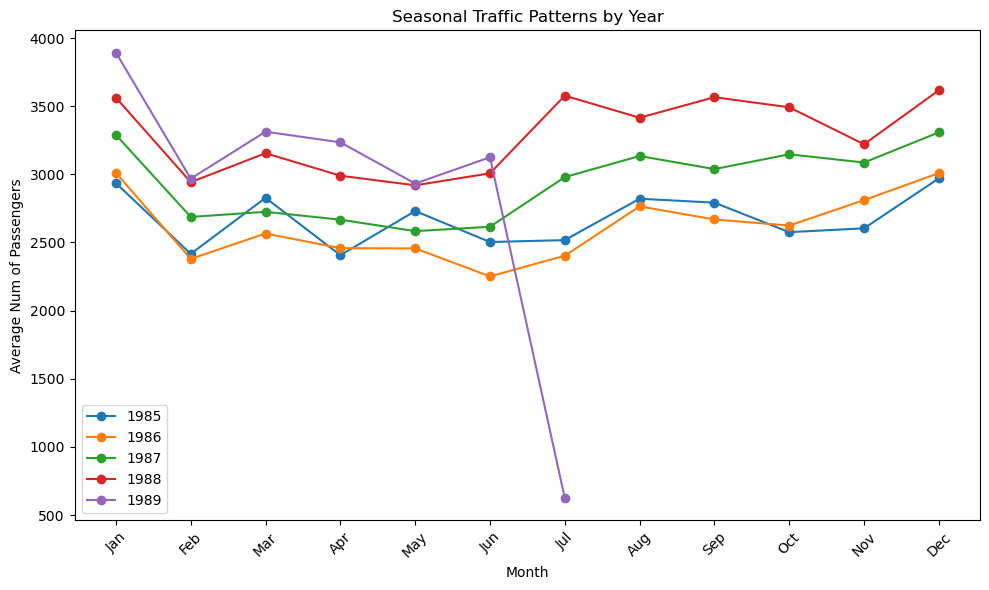

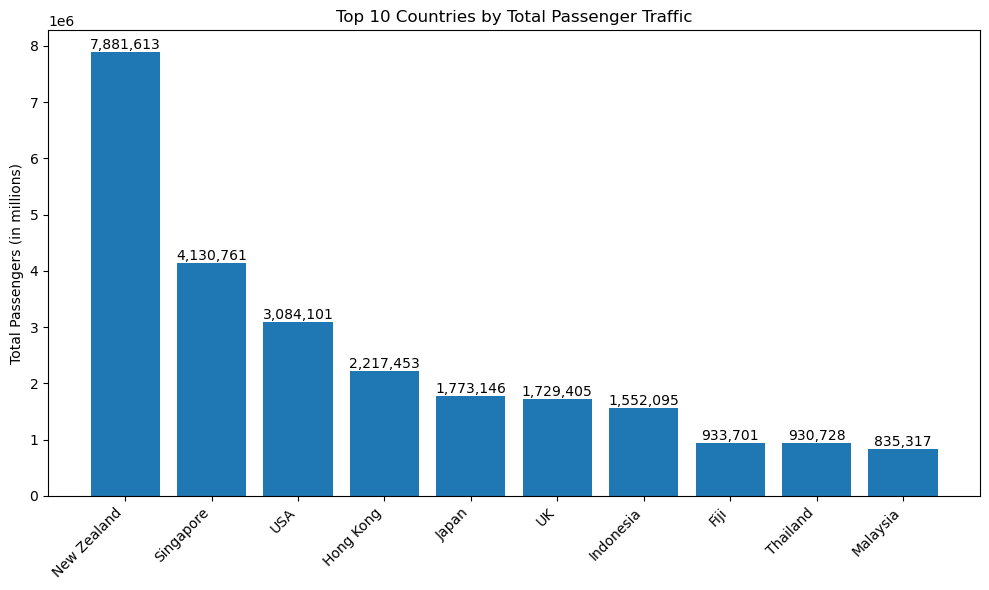

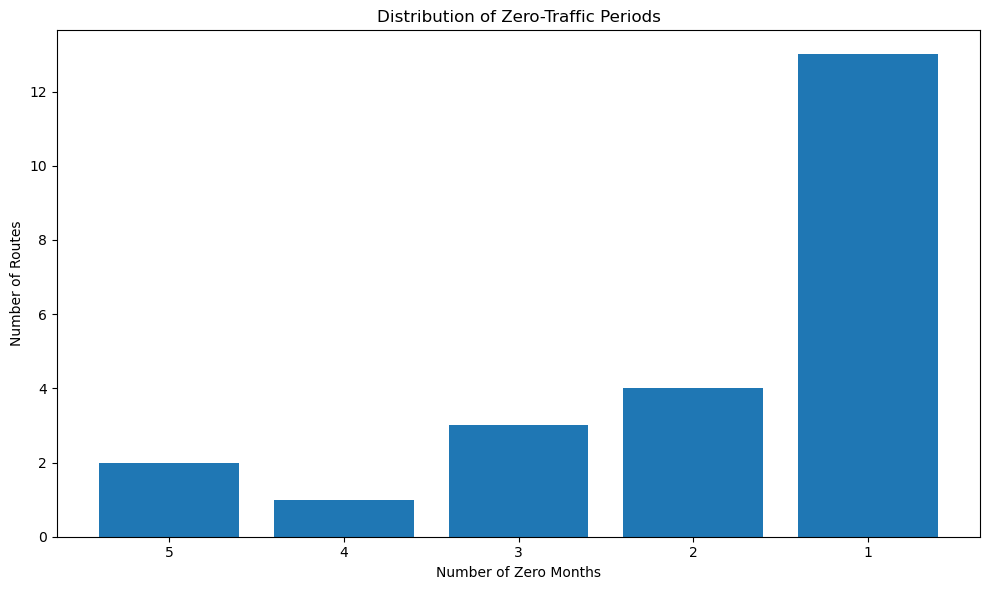

In [13]:
#c)

# Seasonal patterns visualization
plt.figure(figsize=(10, 6))

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# calculate average passngers per month and plots line accordingly
for year in sorted(df['Year'].unique()):
    year_data = df[df['Year'] == year]
    monthly_avg = year_data.groupby('Month_num')['Passengers_Total'].mean()
    
    
    full_monthly = pd.Series(index=range(1, 13), dtype=float)
    full_monthly.update(monthly_avg)
    
    plt.plot(months, full_monthly.values, marker='o', label=str(year))

plt.title('Seasonal Traffic Patterns by Year')
plt.ylabel('Average Num of Passengers')
plt.xlabel('Month')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# passenger traffic visualization
plt.figure(figsize=(10, 6))
country_totals = df.groupby('Country')['Passengers_Total'].sum().sort_values(ascending=False)
# get top 10 countries
top_10 = country_totals.head(10)
# graph bar chart
bars = plt.bar(range(len(top_10)), top_10.values)
plt.title('Top 10 Countries by Total Passenger Traffic')
plt.ylabel('Total Passengers (in millions)')
plt.xticks(range(len(top_10)), top_10.index, rotation=45, ha='right')

# adds count label on top of each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# zero traffic visualization 
plt.figure(figsize=(10, 6))
zero_traffic = df[df['Passengers_Total'] == 0]
routes_with_zeros = zero_traffic['Route'].value_counts()
zero_counts = routes_with_zeros.value_counts().sort_index(ascending=False)

bars = plt.bar(zero_counts.index.astype(str), zero_counts.values)
plt.title('Distribution of Zero-Traffic Periods')
plt.xlabel('Number of Zero Months')
plt.ylabel('Number of Routes')

plt.tight_layout()
plt.show()

In [14]:
# isolate Sydney - Auckland route
route_data = df[df['Route'] == 'Sydney - Auckland'].copy().sort_values('Date')

# create features 
route_data['time_index'] = range(len(route_data))
route_data['month_sin'] = np.sin(2 * np.pi * route_data['Month_num'] / 12)
route_data['month_cos'] = np.cos(2 * np.pi * route_data['Month_num'] / 12)

# add lag features 
route_data['lag_1'] = route_data['Passengers_Total'].shift(1)
route_data['lag_3'] = route_data['Passengers_Total'].shift(3)
route_data['rolling_mean_3'] = route_data['Passengers_Total'].rolling(window=3).mean()

# remove rows with NaN values from lag features
route_data_clean = route_data.dropna()

# feature selection
features = ['Month_num', 'Year', 'time_index', 'month_sin', 'month_cos', 
           'lag_1', 'lag_3', 'rolling_mean_3']

X = route_data_clean[features]
y = route_data_clean['Passengers_Total']

# train/test split
split_point = int(0.8 * len(X))
X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]

# different random forest configurations
rf_configs = {
    'basic': {'n_estimators': 50, 'max_depth': None, 'random_state': 42},
    'some_depth': {'n_estimators': 100, 'max_depth': 5, 'random_state': 42},
    'more_depth': {'n_estimators': 200, 'max_depth': 7, 'random_state': 42}
}

results = {}

for config_name, params in rf_configs.items():
    # train model
    rf_model = RandomForestRegressor(**params)
    rf_model.fit(X_train, y_train)
    
    # make predictions
    y_test_pred = rf_model.predict(X_test)
    
    # evaluate
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # feature importance
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    results[config_name] = {
        'model': rf_model,
        'test_r2': test_r2,
        'test_mae': test_mae,
        'feature_importance': feature_importance
    }

# find best model
best_config = max(results.keys(), key=lambda x: results[x]['test_r2'])
best_result = results[best_config]

print(f'Best model: {best_config}')
print(f"Test R²: {best_result['test_r2']:.3f}")
print(f"Test MAE: {best_result['test_mae']:,.0f}")

# future predictions
best_model = best_result['model']
last_data = route_data_clean.iloc[-1]
future_predictions = []

Best model: some_depth
Test R²: 0.799
Test MAE: 4,272
